In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_df = pd.read_csv('credit_data.csv')

In [3]:
# drop unneeded columns
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# current col names are X1, X2...add better col names
columns = ['Limit','Sex','Education','Marriage','Age','Hist_6',\
           'Hist_5','Hist_4','Hist_3','Hist_2','Hist_1','Bill_6',\
           'Bill_5','Bill_4','Bill_3','Bill_2','Bill_1','Pay_6',\
           'Pay_5','Pay_4','Pay_3','Pay_2','Pay_1','Default']
raw_df.columns = columns

# drop header from first row
raw_df = raw_df.drop([0]).reset_index()

# re-order the columns
columns=['Default','Limit','Sex','Education','Marriage','Age',\
         'Bill_1','Bill_2','Bill_3','Bill_4','Bill_5','Bill_6',\
         'Pay_1','Pay_2','Pay_3','Pay_4','Pay_5','Pay_6',\
         'Hist_1','Hist_2','Hist_3','Hist_4','Hist_5','Hist_6']
raw_df = raw_df[columns]

# replace encoded features with categorical values
raw_df = raw_df.astype(int)
raw_df['Sex'].replace([1,2],['Male','Female'], inplace=True)
raw_df['Education'].replace([0,1,2,3,4,5,6],['Others','Graduate','University','High_School','Others','Others','Others'], inplace=True)
raw_df['Marriage'].replace([0,1,2,3],['Others','Married','Single','Others'], inplace=True)

In [4]:
raw_df

,Default,Limit,Sex,Education,Marriage,Age,Bill_1,Bill_2,Bill_3,Bill_4,...,Pay_3,Pay_4,Pay_5,Pay_6,Hist_1,Hist_2,Hist_3,Hist_4,Hist_5,Hist_6
0,1,20000,Female,University,Married,24,0,0,0,689,...,0,0,689,0,-2,-2,-1,-1,2,2
1,1,120000,Female,University,Single,26,3261,3455,3272,2682,...,1000,1000,1000,0,2,0,0,0,2,-1
2,0,90000,Female,University,Single,34,15549,14948,14331,13559,...,1000,1000,1500,1518,0,0,0,0,0,0
3,0,50000,Female,University,Married,37,29547,28959,28314,49291,...,1100,1200,2019,2000,0,0,0,0,0,0
4,0,50000,Male,University,Married,57,19131,19146,20940,35835,...,9000,10000,36681,2000,0,0,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,220000,Male,High_School,Married,39,15980,31237,88004,208365,...,3047,5003,20000,8500,0,0,0,0,0,0
29996,0,150000,Male,High_School,Single,43,0,5190,8979,3502,...,129,8998,3526,1837,0,0,-1,-1,-1,-1
29997,1,30000,Male,University,Single,37,19357,20582,20878,2758,...,4200,22000,0,0,0,0,-1,2,3,4
29998,1,80000,Male,High_School,Married,41,48944,11855,52774,76304,...,1926,1178,3409,85900,-1,0,0,0,-1,1


percent default cases = 22.12%


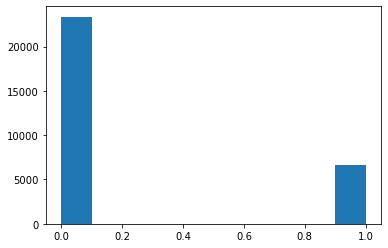

In [5]:
import matplotlib.pyplot as plt

plt.hist(raw_df['Default']);

print('percent default cases = {}%'.format(100*(raw_df['Default'] == 1).sum() / len(raw_df)))

## Split Train, test, val

In [6]:
# Separate train, val, and test data

from sklearn.model_selection import train_test_split

# Separate features from label
X = raw_df.drop(columns='Default')
y = raw_df['Default']

# Hold out 20% test data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Hold out 25% of remainder for validation
#X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

## Create dummies

In [7]:
# One hot encode categoricals for Train, (Val- skip), and Test sets

from sklearn.preprocessing import OneHotEncoder

# Define the categoricals
categoricals = ['Sex','Education','Marriage']

#
# Train data
#
# Initialize
ohe = OneHotEncoder(sparse=False)
# Create a matrix of encoded variables
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])
# Turn the matrix into a dataframe
X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), # use real column names
                           index=X_train.index) # get index position form training data
# Combine encoded categoricals with the numeric training data
X_train_preprocessed = pd.concat([X_train.drop(columns=categoricals), X_train_ohe], axis=1)

#
# Val data - don't need when doing kfold cross val
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_val = ohe.fit_transform(x_val.loc[:, categoricals])
x_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_val.index)
x_val_preprocessed = pd.concat([x_val.drop(columns=categoricals), x_val_ohe], axis=1)

#
# Test data
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_test = ohe.fit_transform(x_test.loc[:, categoricals])
x_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_test.index)
x_test_preprocessed = pd.concat([x_test.drop(columns=categoricals), x_test_ohe], axis=1)

## Scale and KNN (k: 1-20)

In [8]:
# Scale data
from sklearn.preprocessing import StandardScaler

In [9]:
"""
# this takes a long time to run
k_val = []
acc_mean = []
acc_sd = []
for k in range(1,21):
    kf = KFold(shuffle=True)
    knn_acc = []
    for train_idx, test_idx in kf.split(X_train_preprocessed):
        knn = KNeighborsClassifier(n_neighbors=k)
        scaler = StandardScaler()
        scaler.fit(X_train_preprocessed.iloc[train_idx])
        X_train_preprocessed_scaled = scaler.transform(X_train_preprocessed.iloc[train_idx])
        X_test_preprocessed_scaled = scaler.transform(X_train_preprocessed.iloc[test_idx])
        knn.fit(X_train_preprocessed_scaled, y_train.iloc[train_idx])
        acc = knn.score(X_test_preprocessed_scaled, y_train.iloc[test_idx])
        knn_acc.append(acc)
    k_val.append(k)
    acc_mean.append(np.mean(knn_acc))
    acc_sd.append(np.std(knn_acc))
    
    
# Put those lists into a df:
knn_raw_scores = pd.DataFrame(list(zip(k_val, acc_mean, acc_sd)),\
                              columns=['k','mean_acc','sd_acc'])

import pickle
# Pickle the knn scores
with open('knn_raw_scores.pickle', 'wb') as to_write:
    pickle.dump(knn_raw_scores, to_write)

"""

"\n# this takes a long time to run\nk_val = []\nacc_mean = []\nacc_sd = []\nfor k in range(1,21):\n    kf = KFold(shuffle=True)\n    knn_acc = []\n    for train_idx, test_idx in kf.split(X_train_preprocessed):\n        knn = KNeighborsClassifier(n_neighbors=k)\n        scaler = StandardScaler()\n        scaler.fit(X_train_preprocessed.iloc[train_idx])\n        X_train_preprocessed_scaled = scaler.transform(X_train_preprocessed.iloc[train_idx])\n        X_test_preprocessed_scaled = scaler.transform(X_train_preprocessed.iloc[test_idx])\n        knn.fit(X_train_preprocessed_scaled, y_train.iloc[train_idx])\n        acc = knn.score(X_test_preprocessed_scaled, y_train.iloc[test_idx])\n        knn_acc.append(acc)\n    k_val.append(k)\n    acc_mean.append(np.mean(knn_acc))\n    acc_sd.append(np.std(knn_acc))\n    \n    \n# Put those lists into a df:\nknn_raw_scores = pd.DataFrame(list(zip(k_val, acc_mean, acc_sd)),                              columns=['k','mean_acc','sd_acc'])\n\nimport pick

In [10]:
# Read
import pickle
with open('knn_raw_scores.pickle','rb') as read_file:
    knn_raw_scores = pickle.load(read_file)

max accuracy is 0.810 with sd 0.002 at k = 16


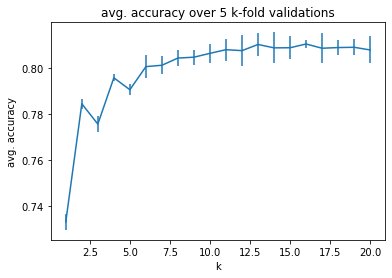

In [11]:
import matplotlib.pyplot as plt

plt.errorbar(knn_raw_scores['k'],\
             knn_raw_scores['mean_acc'],\
             yerr=knn_raw_scores['sd_acc'])
plt.title('avg. accuracy over 5 k-fold validations')
plt.ylabel('avg. accuracy')
plt.xlabel('k');


score = max(knn_raw_scores['mean_acc'])
idx = np.argmax(knn_raw_scores['mean_acc'])
print('max accuracy is {:.3f} with sd {:.3f} at k = {}'\
      .format(score,\
              knn_raw_scores['sd_acc'].iloc[idx],\
              knn_raw_scores['k'].iloc[idx]))

## Scale training data and assess 6 different models

In [12]:
scaler = StandardScaler()
scaler.fit(X_train_preprocessed)
X_train_preprocessed_scaled = scaler.transform(X_train_preprocessed)

In [22]:
"""
from sklearn.model_selection import cross_val_score

model_list = []
scores_mean = []
scores_sd = []

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=16)
knn_scores = cross_val_score(knn, X_train_preprocessed_scaled, y_train, cv=5, scoring='accuracy')
#print('knn accuracy = {:.3f}'.format(np.mean(scores)))
model_list.append('knn')
scores_mean.append(np.mean(knn_scores))
scores_sd.append(np.std(knn_scores))

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train_preprocessed_scaled, y_train, cv=5, scoring='accuracy')
#print('lr accuracy = {:.3f}'.format(np.mean(scores)))
model_list.append('LR')
scores_mean.append(np.mean(lr_scores))
scores_sd.append(np.std(lr_scores))

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb_scores = cross_val_score(nb, X_train_preprocessed_scaled, y_train, cv=5, scoring='accuracy')
#print('nb accuracy = {:.3f}'.format(np.mean(scores)))
model_list.append('NB')
scores_mean.append(np.mean(nb_scores))
scores_sd.append(np.std(nb_scores))

from sklearn.svm import SVC
svc = SVC()
svc_scores = cross_val_score(svc, X_train_preprocessed_scaled, y_train, cv=5, scoring='accuracy')
#print('svc accuracy = {:.3f}'.format(np.mean(scores)))
model_list.append('SVC')
scores_mean.append(np.mean(svc_scores))
scores_sd.append(np.std(svc_scores))

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_scores = cross_val_score(dt, X_train_preprocessed_scaled, y_train, cv=5, scoring='accuracy')
#print('dt accuracy = {:.3f}'.format(np.mean(scores)))
model_list.append('DT')
scores_mean.append(np.mean(dt_scores))
scores_sd.append(np.std(dt_scores))

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, X_train_preprocessed_scaled, y_train, cv=5, scoring='accuracy')
#print('rf accuracy = {:.3f}'.format(np.mean(scores)))
model_list.append('RF')
scores_mean.append(np.mean(rf_scores))
scores_sd.append(np.std(rf_scores))

six_basic_models = pd.DataFrame(list(zip(model_list, scores_mean, scores_sd)),\
                              columns=['model','mean_acc','sd_acc'])


import pickle
with open('six_basic_models.pickle', 'wb') as to_write:
    pickle.dump(six_basic_models, to_write)

"""

In [28]:
# Read
import pickle
with open('six_basic_models.pickle','rb') as read_file:
    six_basic_models = pickle.load(read_file)

  model  mean_acc    sd_acc
0   knn  0.806042  0.002028
1    LR  0.810750  0.002223
2    NB  0.575292  0.035899
3   SVC  0.818375  0.003817
4    DT  0.724083  0.005937
5    RF  0.815250  0.003932


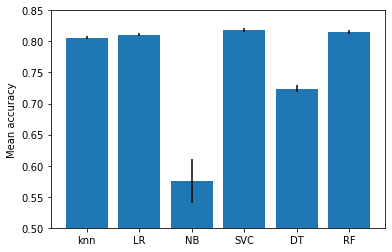

In [30]:
plt.bar(six_basic_models['model'],\
        six_basic_models['mean_acc'],\
        yerr=six_basic_models['sd_acc'])
plt.ylabel('Mean accuracy')
plt.axis([None, None, 0.5, 0.85]);

print(six_basic_models)

## KNN: precision and recall

In [ ]:
# Separate train, val, and test data

from sklearn.model_selection import train_test_split

# Separate features from label
X = raw_df.drop(columns='Default')
y = raw_df['Default']

# Hold out 20% test data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Hold out 25% of remainder for validation
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
# One hot encode categoricals for Train, (Val- skip), and Test sets

from sklearn.preprocessing import OneHotEncoder

# Define the categoricals
categoricals = ['Sex','Education','Marriage']

#
# Train data
#
# Initialize
ohe = OneHotEncoder(sparse=False)
# Create a matrix of encoded variables
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])
# Turn the matrix into a dataframe
X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), # use real column names
                           index=X_train.index) # get index position form training data
# Combine encoded categoricals with the numeric training data
X_train_preprocessed = pd.concat([X_train.drop(columns=categoricals), X_train_ohe], axis=1)

#
# Val data - don't need when doing kfold cross val
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_val = ohe.fit_transform(x_val.loc[:, categoricals])
x_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_val.index)
x_val_preprocessed = pd.concat([x_val.drop(columns=categoricals), x_val_ohe], axis=1)

#
# Test data
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_test = ohe.fit_transform(x_test.loc[:, categoricals])
x_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_test.index)
x_test_preprocessed = pd.concat([x_test.drop(columns=categoricals), x_test_ohe], axis=1)

In [ ]:
# Classification report

lr = LogisticRegression(penalty='none')
lr.fit(X_train_preprocessed, y_train)

y_preds = lr.predict(X_test_preprocessed)
print(classification_report(y_test, y_preds))

In [ ]:
# Confusion matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_test_preprocessed, y_test, ax=ax);